<a href="https://colab.research.google.com/github/Schify/FacExcerciseBook/blob/custom-metric/DL_BHW_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#mounting our google drive so we can load the dataset
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
#A libary that will help us plot the neural network so we can better visualize it
!pip install -q pydot
!apt install graphviz
!pip install keras-tuner

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [5]:
#loading all the necessary libraries for the project
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from tqdm.notebook import tqdm #useful module for progress bars
import logging
import gc
from datetime import datetime
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
from datetime import datetime
!pip install keras_facenet
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model
from keras_facenet import FaceNet
import shutil
import keras_tuner as kt
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from kerastuner.tuners import Hyperband
import keras_tuner as kt
embedder = FaceNet()
OHEC =OneHotEncoder()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [6]:
#reading the csv file that contains the labels with pandas
train_label_raw = pd.read_csv("gdrive/MyDrive/DL_big_homework/train.csv")
val_label_raw = pd.read_csv("gdrive/MyDrive/DL_big_homework/val.csv")

In [7]:
#displaying the training labels
train_label_raw.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [8]:
#dispalying the validation labels
val_label_raw.head()

,file,age,gender,race,service_test
0,val/1.jpg,3-9,Male,East Asian,False
1,val/2.jpg,50-59,Female,East Asian,True
2,val/3.jpg,30-39,Male,White,True
3,val/4.jpg,20-29,Female,Latino_Hispanic,True
4,val/5.jpg,20-29,Male,Southeast Asian,False


In [9]:
#Here we used sklearn in order to onehotencode our data thus preparing it for the CNN network
#We defined a label list to make the predictions possible
label_list=["0-2","10-19","20-29","3-9","30-39","40-49","50-59","60-69",
            "more than 70","Female","Male","Black","East Asian","Indian",
            "Latino_hispanic","Middle_easern", "Southest Asian","White","False","True"]
OHEC =OneHotEncoder()
"""
OHEC.fit(X=[["0-2", "Male", "Black", "False"],["3-9", "Female", "Indian", "True"],
["10-19", "Male", "East Asian", "False"],["20-29", "Male", "Southeast Asian", "False"],
["30-39", "Male", "Latino_Hispanic", "False"],["40-49", "Male", "Middle Eastern", "False"],["50-59", "Male", "White", "False"],
["60-69", "Male", "Middel Eastern", "False"],["more than 70", "Male", "White", "False"]])
"""
#The one hot encoder arranges the inputs in alphabetic order
OHEC.fit(val_label_raw[["age", "gender", "race", "service_test"]])
val_label = OHEC.transform(val_label_raw[["age", "gender", "race", "service_test"]]).toarray()
train_label = OHEC.transform(train_label_raw[["age", "gender", "race", "service_test"]]).toarray()
#We are putting thes together inside this npz dataformat
np.savez("labels.npz", train=train_label, val=val_label)

In [10]:
#loading the labels from the drive
labels=np.load("labels.npz")

In [11]:
#loading the embeddings from the drive (we will split this in the model.fit)
train_embeddings = np.load("gdrive/MyDrive/DL_big_homework/train_embedding2.npz")["train"]
train_labels = np.load("gdrive/MyDrive/DL_big_homework/labels.npz")["train"][0:train_embeddings.shape[0]]
print(train_labels.shape)

(13011, 20)


In [12]:
#loading the test dataset
test_embeddings = np.load("gdrive/MyDrive/DL_big_homework/test_embedding.npz")["val"]
test_labels = np.load("gdrive/MyDrive/DL_big_homework/labels.npz")["val"][0:test_embeddings.shape[0]]
print(test_labels.shape)

(54, 20)


In [13]:
#creating a custom loss function
class MulticatLoss(keras.losses.Loss):
        def __init__(self):
            super(MulticatLoss, self).__init__()
            self.cce = keras.losses.CategoricalCrossentropy()

        def call(self, y_true, y_pred):
            return self.cce(y_true[...,0:9], y_pred[...,0:9])+\
                   self.cce(y_true[...,9:11],y_pred[...,9:11])+\
                   self.cce(y_true[...,11:18],y_pred[...,11:18])+\
                   self.cce(y_true[...,18:20], y_pred[...,18:20])

In [14]:
#creating a metric for the loss function
class MulticatMetric(tf.keras.metrics.Metric):

  def __init__(self, name='category_accuracy', **kwargs):
    super(MulticatMetric, self).__init__(name=name, **kwargs)
    self.accs = [tf.keras.metrics.CategoricalAccuracy() for i in range(4)]
    self.results = 0
    self.limits = [0,9,11,18,20]

  def update_state(self, y_true, y_pred, sample_weight=None):
    for i, acc in enumerate(self.accs): #this is not optimal
      acc.reset_state()
      acc.update_state(y_true[...,self.limits[i]:self.limits[i+1]], y_pred[...,self.limits[i]:self.limits[i+1]])

  def result(self):
    return self.accs[0].result()+\
           self.accs[1].result()+\
           self.accs[2].result()+\
           self.accs[3].result()

    #loops are bad unfortunately
outMetric = MulticatMetric(name="category_accuracy")

In [15]:
outMetric.update_state(np.array([[0,1,0,0,0,0,0,0,0, 1,0, 0,1,0,0,0,0,0, 0,1],
                        [0,1,0,0,0,0,0,0,0, 0,1, 0,0,1,0,0,0,0, 0,1]]),
                        np.array([[0,0.7,0.4,0,0,0,0,0,0, 0.7,0.6, 0.8,0.2,0,0,0,0,0, 1,0],
                         [0,0.7,0.4,0,0,0,0,0,0, 0.7,0.6, 0.8,0.2,0,0,0,0,0, 1,0]]))
tens1 = outMetric.result()
outMetric.update_state(np.array([[0,1,0,0,0,0,0,0,0, 1,0, 0,1,0,0,0,0,0, 0,1],
                        [0,0,1,0,0,0,0,0,0, 1,0, 0,0,1,0,0,0,0, 0,1]]),
                        np.array([[0,0.8,0.4,0,0,0,0,0,0, 0.7,0.6, 0.8,0.2,0,0,0,0,0, 1,0],
                         [0,0.7,0.8,0,0,0,0,0,0, 0.7,0.6, 0.8,0.2,0,0,0,0,0, 1,0]]))
tens2 = outMetric.result()
print(tens1)
print(tens2)
print(tens1+tens2)

tf.Tensor(1.5, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(3.5, shape=(), dtype=float32)


In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_category_accuracy', patience=20)
#creating the neural network
def build_model(hp):
  inputs = keras.Input(shape=(train_embeddings.shape[1],))
  

  hp_activation=hp.Choice('activation', values=["relu","sigmoid"])
  x = keras.layers.Dense(units=hp.Int('units1', min_value=32, max_value=512, step=16), activation=hp.Choice('activation', values=["relu","sigmoid"]))(inputs)
  dp_rate=0.1+hp.Choice('rate1', values=[0.1,0.3,0.4])
  dp_rate2=0.1+hp.Choice('rate2', values=[0.1,0.3,0.4])
  x = keras.layers.Dropout(rate=dp_rate)(x)

  x = keras.layers.Dense(units=hp.Int('units2', min_value=32, max_value=512, step=16), activation=hp.Choice('activation', values=["relu","sigmoid"]))(x)
  x = keras.layers.Dropout(rate=dp_rate2)(x)

  x = keras.layers.Dense(units=hp.Int('units3', min_value=32, max_value=512, step=16), activation=hp.Choice('activation', values=["relu","sigmoid"]),)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dense(units=hp.Int('units4', min_value=32, max_value=512, step=16), activation=hp.Choice('activation', values=["relu","sigmoid"]),)(x)
  x = keras.layers.BatchNormalization()(x)
  #each category needs to have its own softmax activation layer 
  xs = [keras.layers.Dense(values.shape[0], activation="softmax")(x) for values in OHEC.categories_]#separate categories
  outputs = tf.keras.layers.Concatenate()(xs)

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model = keras.Model(inputs = inputs, outputs = outputs, name="OpenFace_extension")
  model.compile(
    loss=MulticatLoss(),#every bit needs to converge, maybe weighting is also needed
    optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
    metrics=[outMetric,"binary_accuracy"])#every bit has to be looked at separately
  return model

In [17]:
#we used hyperband beacuse it has pruning in it
tuner = Hyperband(
    build_model,
    kt.Objective("val_category_accuracy", direction="max"),
    factor=10,
    max_epochs=100,
    directory='output3',
    project_name='big_homework')

INFO:tensorflow:Reloading Oracle from existing project output3/big_homework/oracle.json
INFO:tensorflow:Reloading Tuner from output3/big_homework/tuner0.json


In [18]:
#showing the search space for our model
tuner.search_space_summary()

Search space summary
Default search space size: 8
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 16, 'sampling': None}
rate1 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.3, 0.4], 'ordered': True}
rate2 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.3, 0.4], 'ordered': True}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 16, 'sampling': None}
units3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 16, 'sampling': None}
units4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 16, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [19]:
#initializing the optimization
tuner.search(train_embeddings,train_labels, validation_split=0.2 ,batch_size = 16,epochs=100, callbacks=[callback])

Trial 132 Complete [00h 04m 13s]
val_category_accuracy: 2.0

Best val_category_accuracy So Far: 2.2727272510528564
Total elapsed time: 00h 42m 49s
INFO:tensorflow:Oracle triggered exit


Model: "OpenFace_extension"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 464)          238032      ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 464)          0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 480)          223200      ['dropout[0][0]']                
                                                                                 

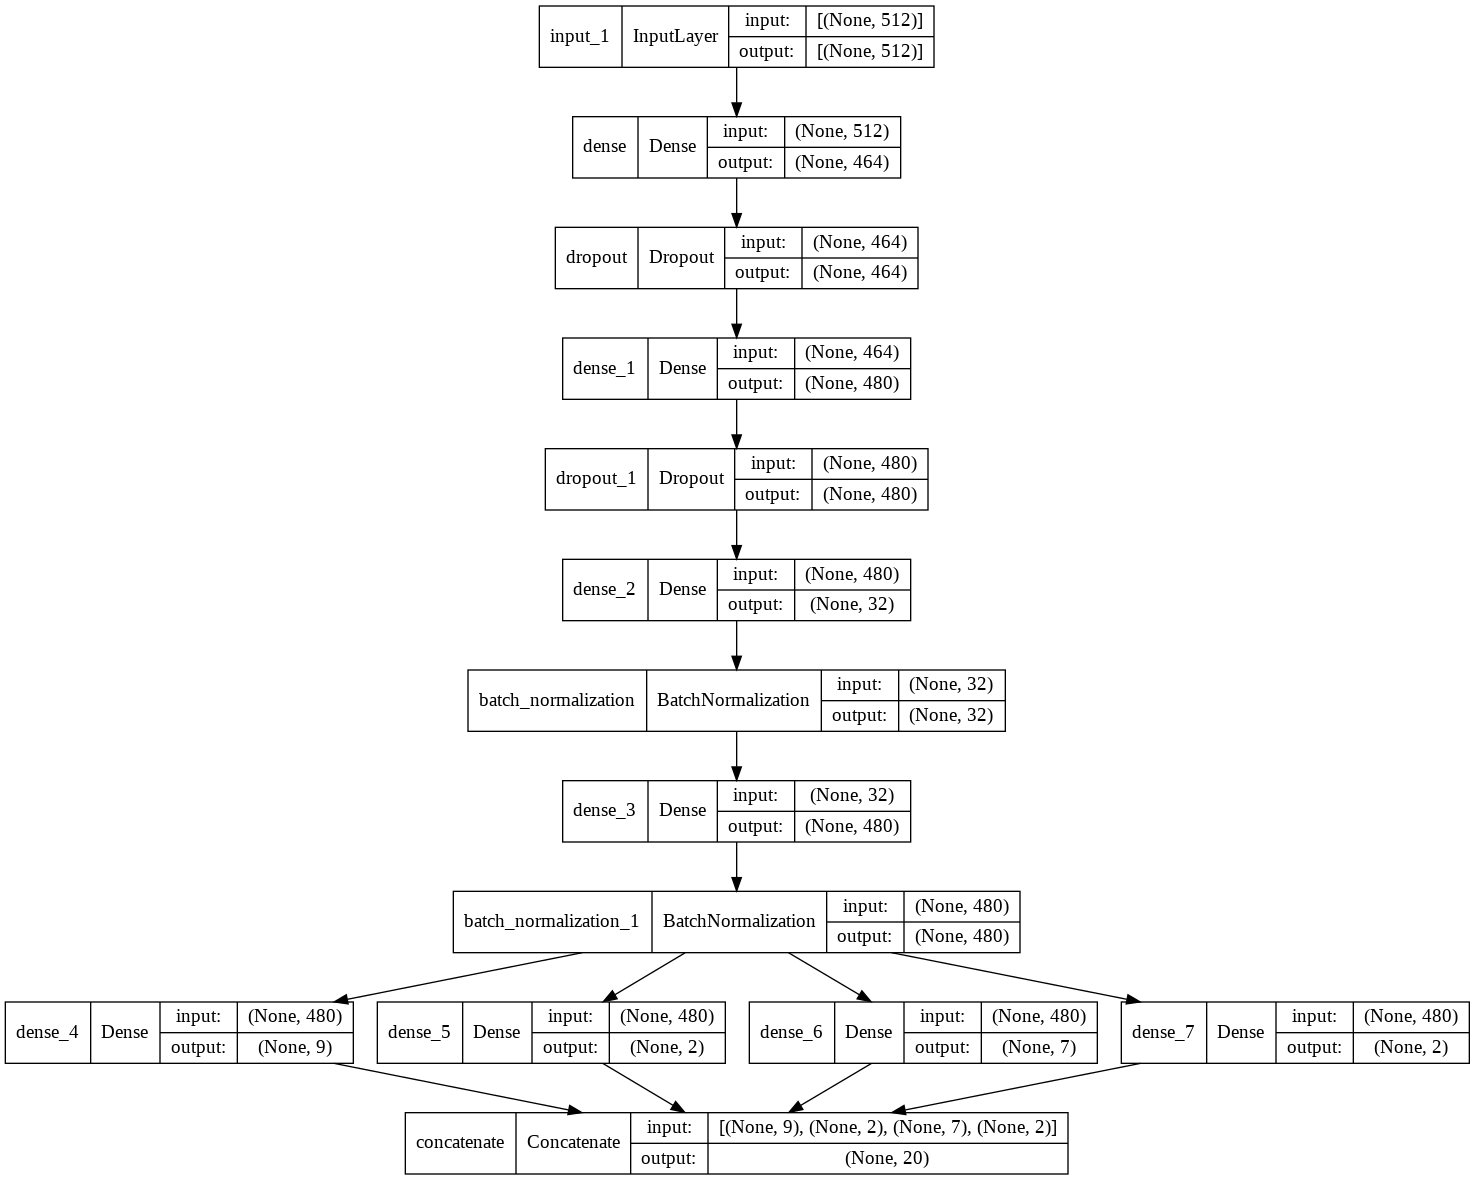

In [20]:
#plotting and defining the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()
plot_model(best_model, show_shapes=True, show_layer_names=True)

In [21]:
#further training the model to get better accuracy
history=best_model.fit(train_embeddings,train_labels, validation_split=0.1 ,batch_size = 32,epochs=300, callbacks=[callback])

Epoch 1/300
366/366 [==============================] - 7s 13ms/step - loss: 5.1604 - category_accuracy: 1.5172 - binary_accuracy: 0.8075 - val_loss: 5.2292 - val_category_accuracy: 1.6818 - val_binary_accuracy: 0.8033
Epoch 2/300
366/366 [==============================] - 4s 12ms/step - loss: 5.1601 - category_accuracy: 1.8276 - binary_accuracy: 0.8073 - val_loss: 5.2308 - val_category_accuracy: 1.5455 - val_binary_accuracy: 0.8042
Epoch 3/300
366/366 [==============================] - 4s 12ms/step - loss: 5.1575 - category_accuracy: 1.5172 - binary_accuracy: 0.8081 - val_loss: 5.2457 - val_category_accuracy: 1.7273 - val_binary_accuracy: 0.8043
Epoch 4/300
366/366 [==============================] - 4s 11ms/step - loss: 5.1508 - category_accuracy: 1.7241 - binary_accuracy: 0.8070 - val_loss: 5.2380 - val_category_accuracy: 1.4545 - val_binary_accuracy: 0.8059
Epoch 5/300
366/366 [==============================] - 4s 12ms/step - loss: 5.1472 - category_accuracy: 1.4138 - binary_accuracy

In [26]:
#predicting with the model
predictions=best_model.predict(test_embeddings)

In [27]:
#creating the test labels for plotting 
test_labels=np.load("gdrive/MyDrive/DL_big_homework/labels.npz")["val"][0:test_embeddings.shape[0]]

In [28]:
#Defining the metrics and creating a function that converts the arrays into labels so we can visualize them
ages = ["0-2","10-19","20-29","3-9","30-39","40-49","50-59","60-69","more than 70"]
sexes = ["Female","Male"]
races = ["Black","East Asian","Indian","Latino_hispanic",
         "Middle_easern", "Southest Asian","White"]

rnds = ["False","True"]
def array_to_labels(arr):
  arr = np.atleast_2d(arr)
  return [ages[np.argmax(arr[:, 0:9])],sexes[np.argmax(arr[:, 9:11])],races[np.argmax(arr[:, 11:18])], rnds[np.argmax(arr[:, 18:20])]]

In [29]:
#defining the predicted and real labels
predicted_labels=[array_to_labels(pred) for pred in predictions]
true_test_labels = [array_to_labels(lab) for lab in test_labels]

In [ ]:
!unzip gdrive/MyDrive/DL_big_homework/fairface.zip -d /content/

Text(0.5, 1.0, "True=['3-9', 'Male', 'Middle_easern', 'True']\npredicted=['20-29', 'Male', 'Indian', 'False']")

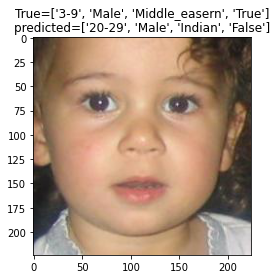

In [32]:
#loading and polotting an image that we will provide at the github repo
img = plt.imread("val/52.jpg")
plt.imshow(img)
plt.title("True="+str(true_test_labels[51])+"\n"+"predicted="+str(predicted_labels[51]))

In [33]:
ages_dict = dict([(lab, i) for i, lab in enumerate(ages)])
sexes_dict = dict([(lab, i) for i, lab in enumerate(sexes)])
races_dict = dict([(lab, i) for i, lab in enumerate(races)])
cat_dicts = [ages_dict,sexes_dict,races_dict]

In [36]:
conf_age = np.zeros((len(ages), len(ages)))
conf_sex = np.zeros((len(sexes), len(sexes)))
conf_race = np.zeros((len(races), len(races)))

confusions = [conf_age,conf_sex,conf_race]

for i, (ytrue, ypred) in enumerate(zip(true_test_labels,predicted_labels)):
  for j in range(3):
    confusions[j][cat_dicts[j][ytrue[j]],cat_dicts[j][ypred[j]]] += 1

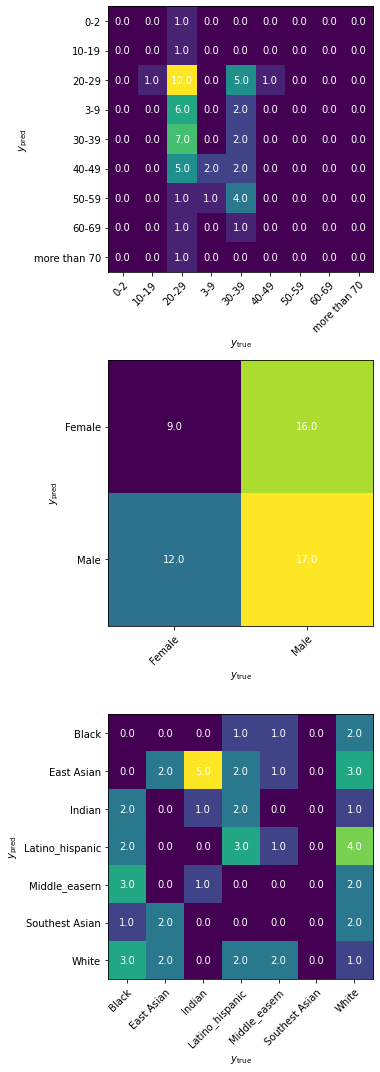

In [65]:
cats = [ages, sexes, races]

figs, axs = plt.subplots(3,1, figsize=(15,15))
for i in range(3):

  im = axs[i].imshow(confusions[i])

# Show all ticks and label them with the respective list entries
  axs[i].set_xticks(np.arange(0.0, len(cats[i]), 1.0))
  axs[i].set_yticks(np.arange(0.0, len(cats[i]), 1.0))
  
  axs[i].set_xticklabels(cats[i])
  axs[i].set_yticklabels(cats[i])
  axs[i].set_xlabel("$y_{\mathrm{true}}$")
  axs[i].set_ylabel("$y_{\mathrm{pred}}$")
# Rotate the tick labels and set their alignment.
  plt.setp(axs[i].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
  for j in range(len(cats[i])):
      for k in range(len(cats[i])):
          text = axs[i].text(k, j, confusions[i][j, k],
                       ha="center", va="center", color="w")
figs.tight_layout()